# Import

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import Tuple, NoReturn
import seaborn as sns


# Dataloader

In [3]:
#Transforms from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_dataset,validation_dataset = random_split(train_dataset,[round(0.9 * len(train_dataset)), round(0.1 * len(train_dataset))])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
BATCH_SIZE = 128
SHUFFLE = True
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)


## Visualizing Data

# Model

In [6]:
class SCNN(nn.Module):
    def __init__(self, activation: str, batch_norm: str, dropout: bool) -> None:
        super().__init__()

        #BASE MODEL
     
        #VGG Style architecture

        #Conv Block 1
        #(Nx3x32x32) -> (Nx32x16x16)
        conv1_1 = nn.Conv2d(in_channels=3, out_channels=32,
                          kernel_size=3, padding=1)
        conv1_2 = nn.Conv2d(in_channels=32, out_channels=32,
                          kernel_size=3, padding=1)
        pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Conv Block 2
        #(Nx32x16x16) -> (Nx64x8x8)
        conv2_1 = nn.Conv2d(in_channels=32, out_channels=64,
                            kernel_size=3, padding=1)
        conv2_2 = nn.Conv2d(in_channels=64, out_channels=64,
                            kernel_size=3, padding=1)
        pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Conv Block 3
        #(Nx64x8x8) -> (Nx128x4x4)
        conv3_1 = nn.Conv2d(in_channels=64, out_channels=128,
                            kernel_size=3, padding=1)
        conv3_2 = nn.Conv2d(in_channels=128, out_channels=128,
                            kernel_size=3, padding=1)
        pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        in_dim = 128*4*4
        fc1 = nn.Linear(in_dim,128)
        fc2 = nn.Linear(128,10)

        activation_layer = None
        dropout_layer = None
        if activation == 'relu':
            activation_layer = nn.ReLU()
        elif activation == 'lrelu':
            activation_layer = nn.LeakyReLU()
        else:
            if activation == 'elu':
                activation_layer = nn.ELU()


        self.conv_net = nn.Sequential(conv1_1,
                                      activation_layer,
                                      conv1_2,
                                      activation_layer,
                                      pool1,
                                      conv2_1,
                                      activation_layer,
                                      conv2_2,
                                      activation_layer,
                                      pool2,
                                      conv3_1,
                                      activation_layer,
                                      conv3_2,
                                      activation_layer,
                                      pool3,
                                      nn.Flatten(start_dim=1),
                                      fc1,
                                      fc2)

        if batch_norm == 'bnorm':
            bnorm1_1 = nn.BatchNorm2d(32)
            bnorm1_2 = nn.BatchNorm2d(32)
            bnorm2_1 = nn.BatchNorm2d(64)
            bnorm2_2 = nn.BatchNorm2d(64)
            bnorm3_1 = nn.BatchNorm2d(128)
            bnorm3_2 = nn.BatchNorm2d(128)

            self.conv_net = nn.Sequential(conv1_1,
                                          bnorm1_1,
                                          activation_layer,
                                          conv1_2,
                                          bnorm1_2,
                                          activation_layer,
                                          pool1,
                                          conv2_1,
                                          bnorm2_1,
                                          activation_layer,
                                          conv2_2,
                                          bnorm2_2,
                                          activation_layer,
                                          pool2,
                                          conv3_1,
                                          bnorm3_1,
                                          activation_layer,
                                          conv3_2,
                                          bnorm3_2,
                                          activation_layer,
                                          pool3,
                                          nn.Flatten(start_dim=1),
                                          fc1,
                                          activation_layer,
                                          fc2)
        elif batch_norm == 'gnorm':

            gnorm1_1 = nn.GroupNorm(8, 32)
            gnorm1_2 = nn.GroupNorm(8, 32)
            gnorm2_1 = nn.GroupNorm(8, 64)
            gnorm2_2 = nn.GroupNorm(8, 64)
            gnorm3_1 = nn.GroupNorm(8, 128)
            gnorm3_2 = nn.GroupNorm(8, 128)

            self.conv_net = nn.Sequential(conv1_1,
                                          gnorm1_1,
                                          activation_layer,
                                          conv1_2,
                                          gnorm1_2,
                                          activation_layer,
                                          pool1,
                                          conv2_1,
                                          gnorm2_1,
                                          activation_layer,
                                          conv2_2,
                                          gnorm2_2,
                                          activation_layer,
                                          pool2,
                                          conv3_1,
                                          gnorm3_1,
                                          activation_layer,
                                          conv3_2,
                                          gnorm3_2,
                                          activation_layer,
                                          pool3,
                                          nn.Flatten(start_dim=1),
                                          fc1,
                                          activation_layer,
                                          fc2)

        else:
            pass




        #############################################################################################
        #Add dropout in similar way, so one code for all
        ###############################################################################################

    def forward(self, x):
        
        
        y = self.conv_net(x)

        return y

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [7]:
cnn = SCNN(activation='relu',batch_norm='bnorm',dropout=False)
params = count_model_params(cnn)
print(cnn)
print(f"Model has {params} learnable parameters")


SCNN(
  (conv_net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


# Training

## Parameters for training

In [8]:
LR = 3e-4
EPOCHS = 50
EVAL_FREQ = 1
SAVE_FREQ = 10
val_loss = 1000

In [10]:
stats = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "accuracy": []
}
init_epoch = 0

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = cnn.to(device)

In [12]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

In [13]:
@torch.no_grad()
def eval_model(model):
    correct = 0
    total = 0
    loss_list = []

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds == labels)[0])
        total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    return accuracy, loss


def save_model(model, optimizer, epoch, stats, val):
    """ Saving model checkpoint """
    if(not os.path.exists("models")):
        os.makedirs("models")
    if (val):

        savepath = f"models/best_val_{stats['model']}.pth"

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats': stats
        }, savepath)
        
    else:

        savepath = f"models/{stats['model']}_checkpoint_epoch_{epoch}.pth"

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats': stats
        }, savepath)

    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]

    return model, optimizer, epoch, stats


def test_model(model):

    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds == labels)[0])
        total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100
    
    return accuracy

In [59]:
loss_hist = []
stats['model'] = 'gnorm'

for epoch in range(EPOCHS):
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i,(images,labels) in progress_bar:

        loss_list = []

        x = images.to(device)
        y_train = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = cnn(x)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, y_train)

        # Getting gradients w.r.t. parameters
        loss.backward()
        loss_list.append(loss.item())

        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
    
    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])
    

    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)
        print(f"Accuracy at epoch {epoch}: {round(accuracy, 2)}%")
    else:
        accuracy, valid_loss = -1, -1
    
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)


    #Saving best validation model
    if valid_loss < val_loss:
        val_loss = valid_loss
        save_model(model=cnn, optimizer=optimizer,
                   epoch=epoch, stats=stats, val = True)


    if epoch % SAVE_FREQ == 0:
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats,val = False)


save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats, val=False)


Epoch 1 Iter 352: loss 0.92120. : 100%|██████████| 352/352 [00:04<00:00, 85.94it/s]


Accuracy at epoch 0: 67.06%


Epoch 2 Iter 352: loss 0.67371. : 100%|██████████| 352/352 [00:04<00:00, 86.72it/s]


Accuracy at epoch 1: 72.42%


Epoch 3 Iter 352: loss 0.67051. : 100%|██████████| 352/352 [00:04<00:00, 86.54it/s]


Accuracy at epoch 2: 75.9%


Epoch 4 Iter 352: loss 0.65194. : 100%|██████████| 352/352 [00:04<00:00, 84.63it/s]


Accuracy at epoch 3: 77.06%


Epoch 5 Iter 352: loss 0.41304. : 100%|██████████| 352/352 [00:04<00:00, 76.67it/s]


Accuracy at epoch 4: 78.14%


Epoch 6 Iter 352: loss 0.29173. : 100%|██████████| 352/352 [00:04<00:00, 77.24it/s]


Accuracy at epoch 5: 77.1%


Epoch 7 Iter 352: loss 0.26749. : 100%|██████████| 352/352 [00:04<00:00, 78.09it/s]


Accuracy at epoch 6: 78.76%


Epoch 8 Iter 352: loss 0.29995. : 100%|██████████| 352/352 [00:04<00:00, 79.85it/s]


Accuracy at epoch 7: 79.94%


Epoch 9 Iter 352: loss 0.22417. : 100%|██████████| 352/352 [00:04<00:00, 79.17it/s]


Accuracy at epoch 8: 78.58%


Epoch 10 Iter 352: loss 0.21514. : 100%|██████████| 352/352 [00:04<00:00, 80.56it/s]


Accuracy at epoch 9: 77.66%


Epoch 11 Iter 352: loss 0.08515. : 100%|██████████| 352/352 [00:04<00:00, 78.03it/s]


Accuracy at epoch 10: 78.64%


Epoch 12 Iter 352: loss 0.11830. : 100%|██████████| 352/352 [00:04<00:00, 79.13it/s]


Accuracy at epoch 11: 78.46%


Epoch 13 Iter 352: loss 0.11667. : 100%|██████████| 352/352 [00:04<00:00, 78.74it/s]


Accuracy at epoch 12: 77.86%


Epoch 14 Iter 352: loss 0.06055. : 100%|██████████| 352/352 [00:04<00:00, 80.74it/s]


Accuracy at epoch 13: 77.74%


Epoch 15 Iter 352: loss 0.02896. : 100%|██████████| 352/352 [00:04<00:00, 79.64it/s]


Accuracy at epoch 14: 77.76%


Epoch 16 Iter 352: loss 0.06208. : 100%|██████████| 352/352 [00:04<00:00, 77.17it/s]


Accuracy at epoch 15: 78.38%


Epoch 17 Iter 352: loss 0.08318. : 100%|██████████| 352/352 [00:04<00:00, 80.47it/s]


Accuracy at epoch 16: 76.98%


Epoch 18 Iter 352: loss 0.03984. : 100%|██████████| 352/352 [00:04<00:00, 81.16it/s]


Accuracy at epoch 17: 79.1%


Epoch 19 Iter 352: loss 0.08454. : 100%|██████████| 352/352 [00:04<00:00, 79.94it/s]


Accuracy at epoch 18: 79.3%


Epoch 20 Iter 352: loss 0.10714. : 100%|██████████| 352/352 [00:04<00:00, 78.48it/s]


Accuracy at epoch 19: 78.4%


Epoch 21 Iter 352: loss 0.09614. : 100%|██████████| 352/352 [00:04<00:00, 80.22it/s]


Accuracy at epoch 20: 78.16%


Epoch 22 Iter 352: loss 0.03041. : 100%|██████████| 352/352 [00:04<00:00, 79.78it/s]


Accuracy at epoch 21: 79.82%


Epoch 23 Iter 352: loss 0.07696. : 100%|██████████| 352/352 [00:04<00:00, 80.41it/s]


Accuracy at epoch 22: 77.5%


Epoch 24 Iter 352: loss 0.07847. : 100%|██████████| 352/352 [00:04<00:00, 79.87it/s]


Accuracy at epoch 23: 79.44%


Epoch 25 Iter 352: loss 0.03658. : 100%|██████████| 352/352 [00:04<00:00, 78.51it/s]


Accuracy at epoch 24: 79.92%


Epoch 26 Iter 352: loss 0.00578. : 100%|██████████| 352/352 [00:04<00:00, 82.46it/s]


Accuracy at epoch 25: 78.78%


Epoch 27 Iter 352: loss 0.10492. : 100%|██████████| 352/352 [00:04<00:00, 87.46it/s]


Accuracy at epoch 26: 79.04%


Epoch 28 Iter 352: loss 0.04016. : 100%|██████████| 352/352 [00:04<00:00, 85.94it/s]


Accuracy at epoch 27: 79.8%


Epoch 29 Iter 352: loss 0.04765. : 100%|██████████| 352/352 [00:04<00:00, 86.94it/s]


Accuracy at epoch 28: 79.42%


Epoch 30 Iter 352: loss 0.02540. : 100%|██████████| 352/352 [00:04<00:00, 82.86it/s]


Accuracy at epoch 29: 78.5%


Epoch 31 Iter 352: loss 0.00685. : 100%|██████████| 352/352 [00:04<00:00, 84.45it/s]


Accuracy at epoch 30: 79.4%


Epoch 32 Iter 352: loss 0.05488. : 100%|██████████| 352/352 [00:04<00:00, 84.04it/s]


Accuracy at epoch 31: 78.22%


Epoch 33 Iter 352: loss 0.00872. : 100%|██████████| 352/352 [00:04<00:00, 82.53it/s]


Accuracy at epoch 32: 79.22%


Epoch 34 Iter 352: loss 0.02755. : 100%|██████████| 352/352 [00:04<00:00, 82.87it/s]


Accuracy at epoch 33: 79.6%


Epoch 35 Iter 352: loss 0.06940. : 100%|██████████| 352/352 [00:04<00:00, 80.75it/s]


Accuracy at epoch 34: 79.62%


Epoch 36 Iter 352: loss 0.01981. : 100%|██████████| 352/352 [00:04<00:00, 83.34it/s]


Accuracy at epoch 35: 79.2%


Epoch 37 Iter 352: loss 0.01816. : 100%|██████████| 352/352 [00:04<00:00, 84.47it/s]


Accuracy at epoch 36: 79.9%


Epoch 38 Iter 352: loss 0.07983. : 100%|██████████| 352/352 [00:04<00:00, 84.65it/s]


Accuracy at epoch 37: 79.46%


Epoch 39 Iter 352: loss 0.02430. : 100%|██████████| 352/352 [00:04<00:00, 86.04it/s]


Accuracy at epoch 38: 79.08%


Epoch 40 Iter 352: loss 0.05367. : 100%|██████████| 352/352 [00:04<00:00, 84.41it/s]


Accuracy at epoch 39: 79.1%


Epoch 41 Iter 352: loss 0.01182. : 100%|██████████| 352/352 [00:04<00:00, 86.16it/s]


Accuracy at epoch 40: 79.52%


Epoch 42 Iter 352: loss 0.02802. : 100%|██████████| 352/352 [00:04<00:00, 87.37it/s]


Accuracy at epoch 41: 79.88%


Epoch 43 Iter 352: loss 0.00189. : 100%|██████████| 352/352 [00:04<00:00, 86.60it/s]


Accuracy at epoch 42: 79.66%


Epoch 44 Iter 352: loss 0.01557. : 100%|██████████| 352/352 [00:04<00:00, 87.04it/s]


Accuracy at epoch 43: 78.5%


Epoch 45 Iter 352: loss 0.00241. : 100%|██████████| 352/352 [00:04<00:00, 87.78it/s]


Accuracy at epoch 44: 79.78%


Epoch 46 Iter 352: loss 0.03238. : 100%|██████████| 352/352 [00:04<00:00, 87.22it/s]


Accuracy at epoch 45: 79.98%


Epoch 47 Iter 352: loss 0.02327. : 100%|██████████| 352/352 [00:04<00:00, 86.33it/s]


Accuracy at epoch 46: 79.56%


Epoch 48 Iter 352: loss 0.02746. : 100%|██████████| 352/352 [00:04<00:00, 84.73it/s]


Accuracy at epoch 47: 80.12%


Epoch 49 Iter 352: loss 0.04205. : 100%|██████████| 352/352 [00:04<00:00, 83.54it/s]


Accuracy at epoch 48: 79.44%


Epoch 50 Iter 352: loss 0.02773. : 100%|██████████| 352/352 [00:04<00:00, 85.56it/s]


Accuracy at epoch 49: 78.32%


# Testing

# Activation Visualization

In [15]:
savepath = os.path.join(os.getcwd(), "models", "best_val_checkpoint_bnorm.pth")
model,optimizer,epoch,stats= load_model(model=cnn,optimizer=optimizer,savepath=savepath)

In [16]:
#Code from https://discuss.pytorch.org/t/visualize-feature-map/29597/6 {PyTorch Forum}
# Visualize feature maps
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [17]:
datait = iter(test_loader)

In [18]:
images,labels = datait.next()


In [19]:
#Code from https://discuss.pytorch.org/t/visualize-feature-map/29597/6 {PyTorch Forum}
activation = {}
model.conv_net[0].register_forward_hook(get_activation('activation_conv1_1'))
model.conv_net[3].register_forward_hook(get_activation('activation_conv1_2'))
model.conv_net[7].register_forward_hook(get_activation('activation_conv2_1'))
model.conv_net[10].register_forward_hook(get_activation('activation_conv2_2'))
model.conv_net[14].register_forward_hook(get_activation('activation_conv3_1'))
model.conv_net[17].register_forward_hook(get_activation('activation_conv3_2'))

output = model(images[0].unsqueeze(0).to(device))
# print(output.shape)




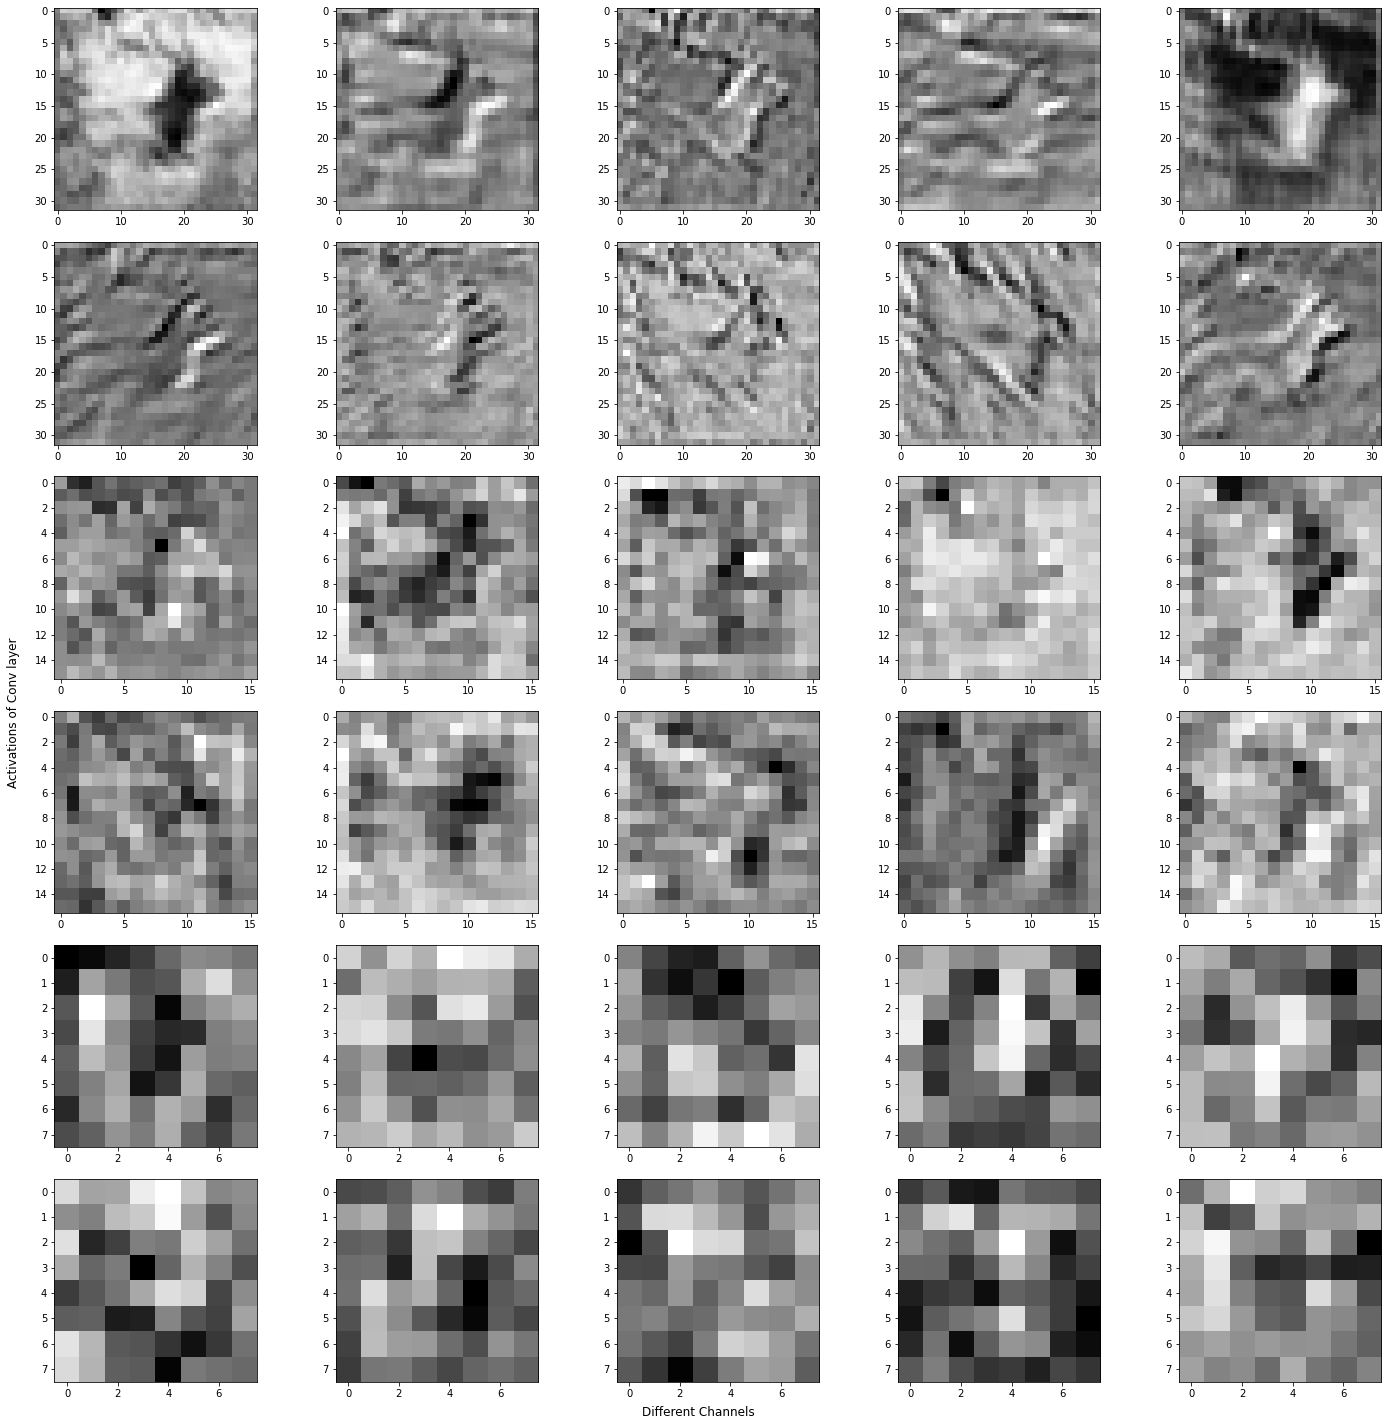

In [20]:
num_plot = 5
fig, axarr = plt.subplots(6, num_plot, figsize=(20, 20))
fig.supxlabel('Different Channels')
fig.supylabel('Activations of Conv layer')
fig.tight_layout()

for cnt,(k, v) in zip(range(6),activation.items()):
    act = activation[k].squeeze()    
    for idx in range(num_plot):
        axarr[cnt,idx].imshow(act[idx].cpu().numpy(),cmap="gray")

# Kernel Visualization 

In [26]:
# https: // github.com/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb

def plot_rgb(weights):
   
    n_filters = 5
    fig,ax = plt.subplots(1,n_filters,figsize = (8,8))


    for i in range(n_filters):
        weight = weights[i]
        weight = weight - torch.min(weight)
        weight = weight / torch.max(weight)
        # weight.shape
       
        ax[i].imshow(weight.permute(1,2,0).cpu().numpy())
    plt.show()

def plot_single_channel(weights):

    n_filters = 5
    n_channels = 5
    fig, ax = plt.subplots(n_filters, n_channels,figsize=(8, 8))

    for i in  range(n_filters):
        for j in range(n_channels):
            # print(i,j)
            weight = weights[i,j]
            weight = weight - torch.min(weight)
            weight = weight / torch.max(weight)

            ax[i,j].imshow(weight.cpu().numpy())
            ax[i, j].axis('off')
            ax[i, j].set_title(str(i)+str(j))
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
    
    # plt.tight_layout()
    plt.show()


In [29]:
def plot_weights(model,layer_num):

    layer = model.conv_net[layer_num]
    print(layer)
    
    if isinstance(layer,nn.Conv2d):
        weight_tensor = layer.weight.data.detach()
 
        if weight_tensor.shape[1] == 3:
            plot_rgb(weight_tensor)
        else:
            
            plot_single_channel(weight_tensor)



Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


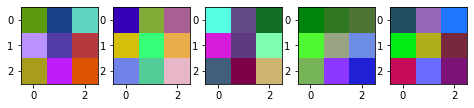

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


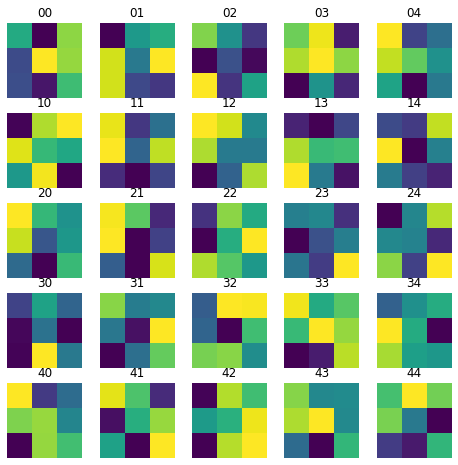

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


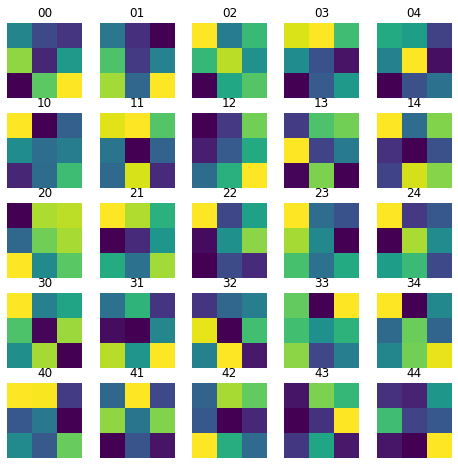

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


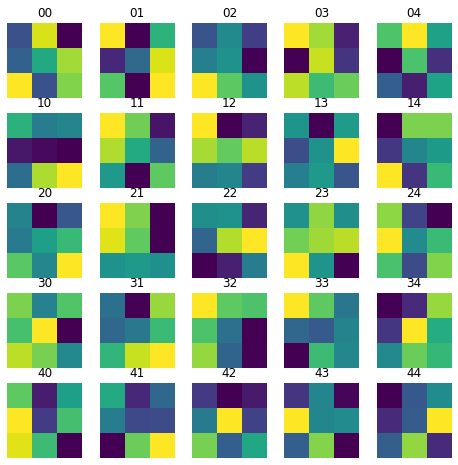

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


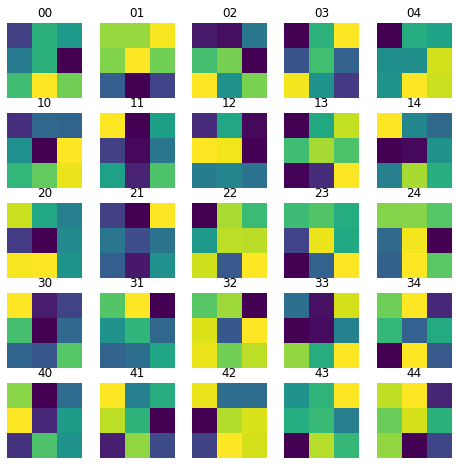

Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


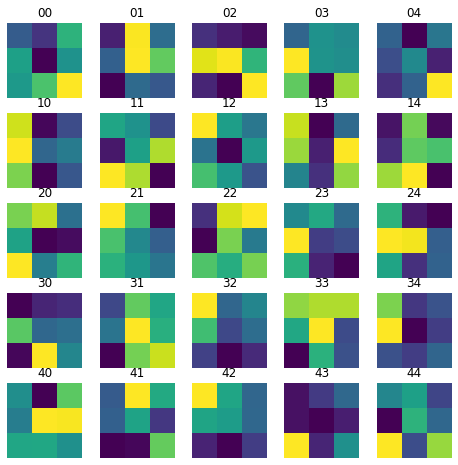

In [30]:
plot_weights(model,0)
plot_weights(model,3)
plot_weights(model,7)
plot_weights(model,10)
plot_weights(model,14)
plot_weights(model, 17)
